<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT22/blob/notanumber-lab4/Lab4/notanumber_lab4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [2]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [5]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**

**Define domain and mesh**

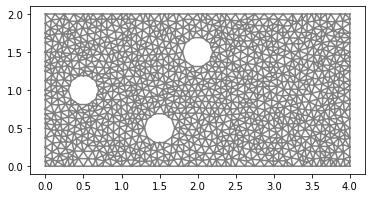

In [6]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [7]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 

d = Function(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

In [8]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

# **Results**

**Define and solve variational problem**

In [9]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
E = 1.0e10
nu = 0.3
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


18

**Visualize solution and export files**

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


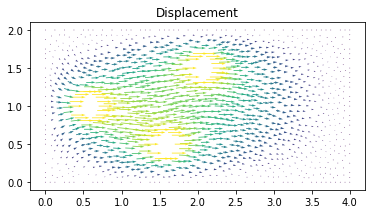

In [10]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Update mesh**

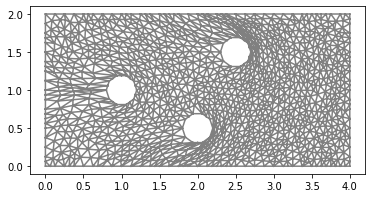

In [11]:
ALE.move(mesh, d)
plt.figure()
plot(mesh)
plt.show()

# **Discussion**

A Elasticity equation was solved with a finite element method.